<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 2: Variational Autoencoders
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [1]:
name = 'Matin Mb'
std_id = '400102114'

In [2]:
import numpy as np
from tqdm import trange
from matplotlib import pyplot as plt

import torch
from torch import nn
from torchvision import datasets, transforms
from torch.optim import Adam

from torch.utils.data import DataLoader, ConcatDataset

In [3]:
# Get cpu, gpu or mps device for training.
device = ("cuda" if torch.cuda.is_available()
          else "mps" if torch.backends.mps.is_available()
          else "cpu")
print(f"Using {device} device")

Using cuda device


# Dataset (5 points)

Download the MNIST dataset and merge the train and test datasets for training the generative model.

In [4]:
# TODO: Define transformations
transform = transforms.Compose([transforms.ToTensor()])

# Load train and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Merge the two datasets to train the model on the images.

In [5]:
# TODO: Concatenate train and test datasets
merged_dataset = ConcatDataset([train_dataset, test_dataset])
merged_loader = DataLoader(merged_dataset, batch_size=64, shuffle=True)


# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


print(f'The size of the merged dataset is {len(merged_loader.dataset)}')

The size of the merged dataset is 70000


# EDA (10 points)

Plot the distribution of each class in the dataset.

In [6]:
def plot_class_distribution(dataloader):
    # TODO: Initialize a dictionary to count occurrences of each class
    class_counts = {i: 0 for i in range(10)}

    # TODO: Iterate through the DataLoader to count the labels
    for _, labels in dataloader:
        for label in labels:
            class_counts[label.item()] += 1

    # TODO: Plot the histogram
    plt.bar(class_counts.keys(), class_counts.values(), edgecolor='black')
    plt.xlabel("Digit Class")
    plt.ylabel("Frequency")
    plt.title("Distribution of Each Class in the MNIST Dataset")
    plt.xticks(range(10))
    plt.show()

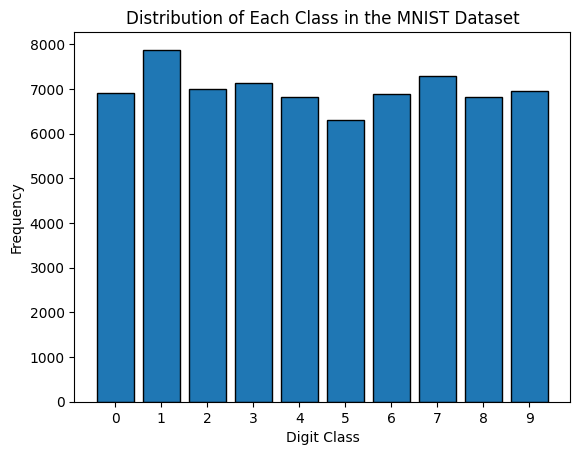

In [7]:
plot_class_distribution(merged_loader)

Plot the average of each class in the dataset.

In [8]:
def plot_class_averages(dataloader):
    # TODO: Iterate over the DataLoader to accumulate sums and counts
    class_sums = {i: torch.zeros((28, 28)) for i in range(10)}
    class_counts = {i: 0 for i in range(10)}

    for images, labels in dataloader:
        for img, label in zip(images, labels):
            class_sums[label.item()] += img.squeeze(0)  # Squeeze to remove the channel dimension
            class_counts[label.item()] += 1

    # TODO: Calculate the average images for each class
    class_averages = {i: class_sums[i] / class_counts[i] for i in range(10)}

    # TODO: Plot the averages
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(class_averages[i], cmap="gray")
        plt.title(f"Class {i}")
        plt.axis("off")

    plt.suptitle("Average Images of Each Class in the MNIST Dataset")
    plt.show()
    # pass

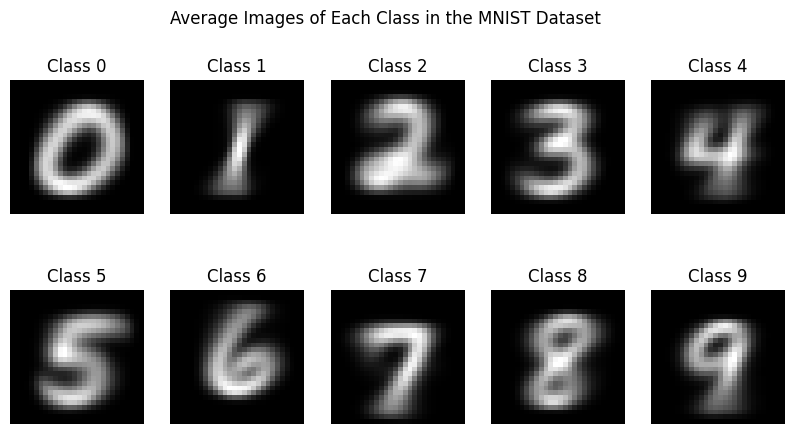

In [9]:
plot_class_averages(merged_loader)

# Variational Autoencoder (25 points)

In [10]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # Define encoder layers
        self.enc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(negative_slope=0.2)
        )

        # Mean and log variance layers for latent space
        self.mean_fc = nn.Linear(latent_dim, 2)
        self.logvar_fc = nn.Linear(latent_dim, 2)

        # Define decoder layers
        self.dec = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        x = self.enc(x)
        mu, logvar = self.mean_fc(x), self.logvar_fc(x)
        return mu, logvar

    def reparametrize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std).to(device)
        return mu + std * epsilon

    def decode(self, z):
        return self.dec(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar


In [11]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []

# Training (20 points)

Define the loss function for training the VAE. The loss functions should be a combination of the reconstruction loss and the KL-divergence loss. You can choose to increase the weight of these losses to achieve better results.

In [12]:
def loss_function(x, x_hat, mean, log_var):

    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = -  torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / 2

    return reproduction_loss + KLD

Now you must train your network using the loss function you defined earlier. Make sure to plot and monitor the training loss over epochs.

In [13]:
def plot_losses(losses):
    # TODO
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("VAE Training Loss Over Epochs")
    plt.legend()
    plt.show()
    pass



def train(model, optimizer, n_epochs, device=device, input_dim=784):
    model.train()
    epoch_losses = []  # List to store average loss for each epoch

    for epoch in range(n_epochs):
        total_loss = 0
        for idx, (data, _) in enumerate(train_loader):
            data = data.view(batch_size, input_dim).to(device)

            optimizer.zero_grad()

            reconstructed, mu, logvar = model(data)
            batch_loss = loss_function(data, reconstructed, mu, logvar)

            total_loss += batch_loss.item()

            batch_loss.backward()
            optimizer.step()

        avg_loss = total_loss / (idx * batch_size)  # Corrected for zero indexing
        epoch_losses.append(avg_loss)  # Store average loss for the epoch
        print(f"Epoch {epoch + 1}\tAverage Loss: {avg_loss:.4f}")

    # Plotting the loss over epochs
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, n_epochs + 1), epoch_losses, marker='o')
    plt.title('Training Loss per Epoch')
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.xticks(range(1, n_epochs + 1))
    plt.grid()
    plt.show()

    return epoch_losses  # Return the list of epoch losses if needed


Epoch 1	Average Loss: 179.8098
Epoch 2	Average Loss: 162.2088
Epoch 3	Average Loss: 157.8183
Epoch 4	Average Loss: 155.3334
Epoch 5	Average Loss: 153.6495
Epoch 6	Average Loss: 152.2540
Epoch 7	Average Loss: 150.9636
Epoch 8	Average Loss: 150.0007
Epoch 9	Average Loss: 149.0932
Epoch 10	Average Loss: 148.4894
Epoch 11	Average Loss: 147.8380
Epoch 12	Average Loss: 147.3430
Epoch 13	Average Loss: 146.8077
Epoch 14	Average Loss: 146.4391
Epoch 15	Average Loss: 145.9380
Epoch 16	Average Loss: 145.5999
Epoch 17	Average Loss: 145.1818
Epoch 18	Average Loss: 145.0674
Epoch 19	Average Loss: 144.5761
Epoch 20	Average Loss: 144.4485
Epoch 21	Average Loss: 144.0834
Epoch 22	Average Loss: 143.8437
Epoch 23	Average Loss: 143.5432
Epoch 24	Average Loss: 143.4167
Epoch 25	Average Loss: 143.2040
Epoch 26	Average Loss: 142.9333
Epoch 27	Average Loss: 142.7797
Epoch 28	Average Loss: 142.4290
Epoch 29	Average Loss: 142.4219
Epoch 30	Average Loss: 142.1865
Epoch 31	Average Loss: 142.0777
Epoch 32	Average 

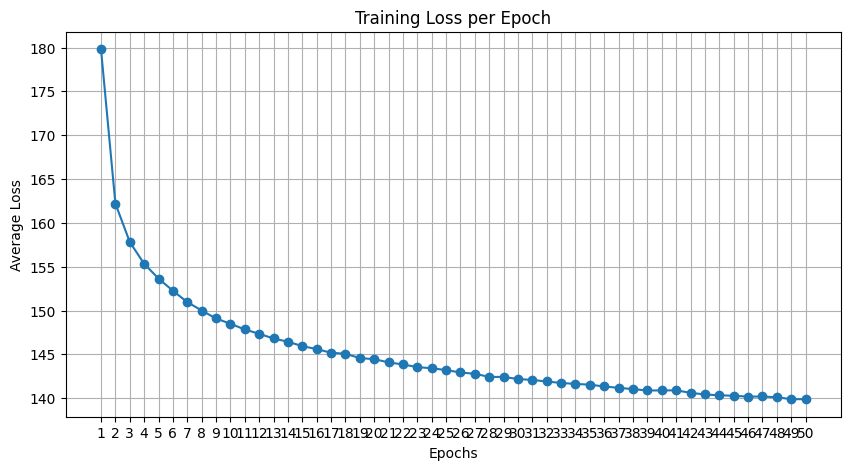

In [14]:
losses = train(model, optimizer, n_epochs=50, device=device)

In [15]:
losses

[179.809787063726,
 162.2088151639451,
 157.81827247887102,
 155.3333834222402,
 153.64948294357785,
 152.253966751226,
 150.96363098654007,
 150.00067542583994,
 149.09317878430195,
 148.48943885968802,
 147.83798727045075,
 147.34300701364253,
 146.80768476432075,
 146.43911951233827,
 145.93800365518052,
 145.59986191178004,
 145.18176048622703,
 145.06740133295074,
 144.576093065265,
 144.44847840476314,
 144.08341447986228,
 143.84369218880425,
 143.5431622691465,
 143.41665402624164,
 143.2040471423727,
 142.93329760212333,
 142.77968484257616,
 142.4290377354184,
 142.42192400746035,
 142.18649577094638,
 142.07767627034642,
 141.9060219343437,
 141.73336993948246,
 141.62725592458784,
 141.54018153628442,
 141.33187094049978,
 141.17992006534328,
 141.03243998787042,
 140.87624302222454,
 140.88120862244367,
 140.89509913984244,
 140.6103972930144,
 140.42000497248017,
 140.32988013877295,
 140.27839370956804,
 140.17662259364565,
 140.1912248767477,
 140.10372670270763,
 139.8

# The Encoder (20 points)

Let's first take a look at the encoder. Start by visualizing the latent dimension for the merged dataset.

In [16]:
def visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization'):
    # TODO: Iterate over the dataloader and plot the latent space
    vae.eval()
    all_means, all_labels = [], []
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            if i >= batch_count:
                break
            images = images.view(images.size(0), -1).to(device)
            mean, _ = vae.encode(images)
            all_means.append(mean.cpu())
            all_labels.extend(labels.cpu().numpy())

    all_means = torch.cat(all_means).numpy()

    # Plot the means in the latent space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_means[:, 0], all_means[:, 1], c=all_labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(title)
    plt.show()

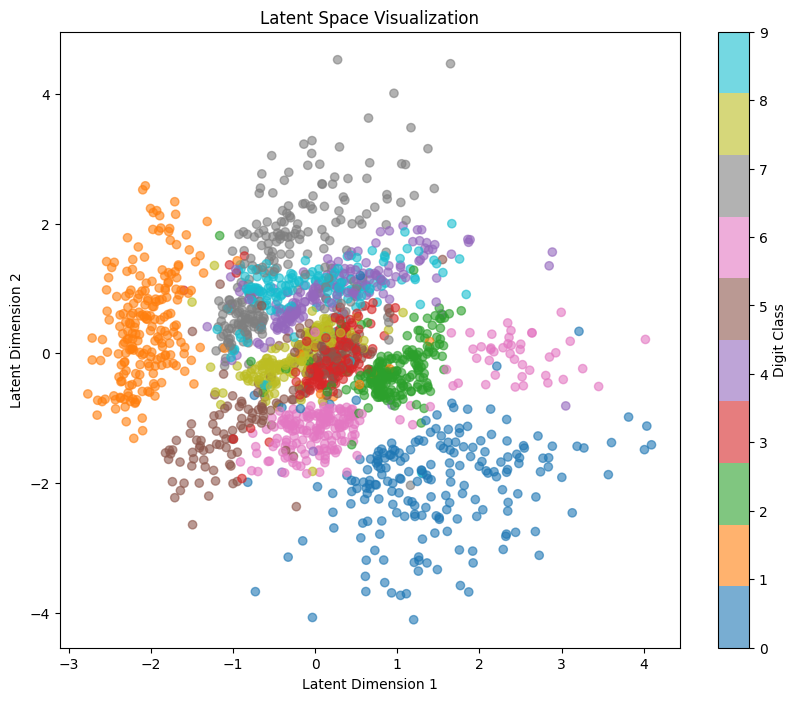

In [17]:
visualize(model, merged_loader)

Imagine if the input data for the encoder followed a very different distribution. Invert the images in the original datset and plot the latent dimension once more to show the difference.

In [18]:
def inverted_visualize(vae, dataloader, batch_count=30, title='Latent Space Visualization (Inverted Images)'):
    # TODO: Iterate over the inverted dataloader and plot the latent space
    vae.eval()
    all_means, all_labels = [], []
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader):
            if i >= batch_count:
                break

            # Invert the images by subtracting from 1
            inverted_images = 1 - images
            inverted_images = inverted_images.view(inverted_images.size(0), -1).to(device)

            # Get latent mean for inverted images
            mean, _ = vae.encode(inverted_images)
            all_means.append(mean.cpu())
            all_labels.extend(labels.cpu().numpy())

    all_means = torch.cat(all_means).numpy()

    # Plot the means in the latent space for inverted images
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(all_means[:, 0], all_means[:, 1], c=all_labels, cmap='tab10', alpha=0.6)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title(title)
    plt.show()


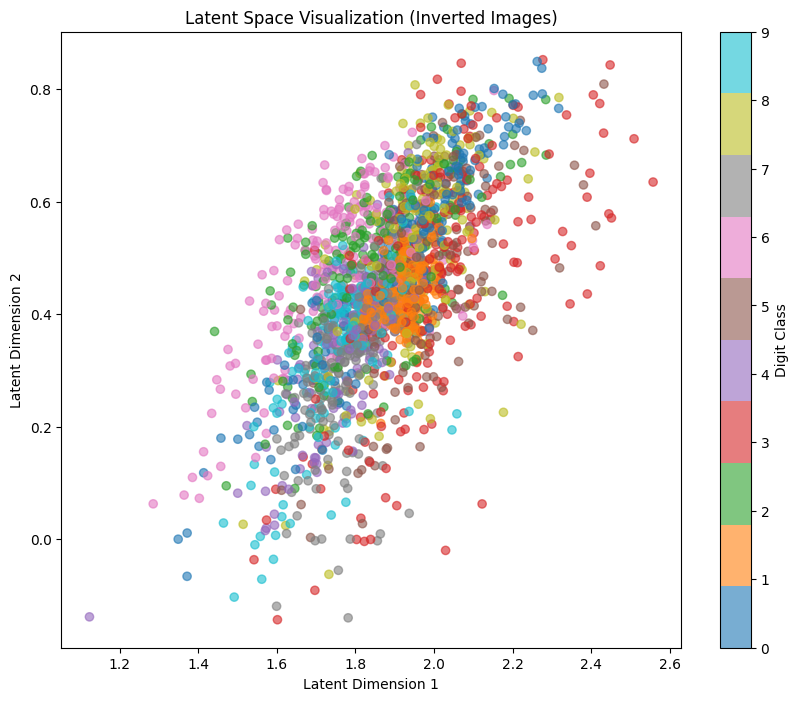

In [19]:
inverted_visualize(model, merged_loader)

Explain how the difference in the latent dimension allows us to detect data samples that don't follow the original distribution. How can this difference be used for anomaly detection? If we had used an autoencoder instead, what would be our observation then?

*`Your Answer:`*

 In a Variational Autoencoder (VAE), the latent space is structured and regularized, typically as a standard Gaussian distribution, which encourages the model to place similar data points close together in this latent space. When a data sample does not follow the original distribution (e.g., it is an anomalous or outlier sample), it will likely be mapped to a less probable region in the latent space—either far from the dense clusters of typical samples or outside of the high-density regions of the latent distribution. This deviation can be detected by measuring the likelihood or reconstruction error: anomalies will generally have a lower likelihood or a higher reconstruction error due to their unusual latent representations.

In an autoencoder, however, the latent space is not regularized to follow a specific distribution. This lack of structure means that outliers might not necessarily be mapped to distinctly different areas in the latent space. While an autoencoder can still indicate anomalies through high reconstruction errors, it lacks the probabilistic interpretability of a VAE, where latent positions directly indicate data likelihood.



# The Decoder (20 points)

In this section we are going to test the properties of the decoder. First implement a function to create samples based on the input mean and variance.

In [20]:
def generate_digit(mean, var):
    # TODO: Return the generated image
    # Create a tensor from mean and variance for sampling
    z_sampled = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    decoded_x = model.decode(z_sampled)

    # Reshape the output to a 2D array
    digit_image = decoded_x.detach().cpu().reshape(28, 28)

    # Plot the digit
    plt.title(f'[{mean}, {var}]')
    plt.imshow(digit_image, cmap='gray')
    plt.axis('off')  # Hide axes
    plt.show()


Now using this function plot the decoded output sampled from a uniform distribution from -1 to +1.

In [21]:
def plot_latent_space(model, scale=1.0, grid_size=25, digit_dimension=28, figure_size=15):
    # TODO: Display a n*n 2D manifold of digits and construct a grid
    canvas = np.zeros((digit_dimension * grid_size, digit_dimension * grid_size))

    # TODO: Generate images for the grid
    grid_x_values = np.linspace(-scale, scale, grid_size)
    grid_y_values = np.linspace(-scale, scale, grid_size)[::-1]

    for i, y_value in enumerate(grid_y_values):
        for j, x_value in enumerate(grid_x_values):
            z_input = torch.tensor([[x_value, y_value]], dtype=torch.float).to(device)
            decoded_x = model.decode(z_input)
            digit_image = decoded_x[0].detach().cpu().reshape(digit_dimension, digit_dimension)
            canvas[i * digit_dimension : (i + 1) * digit_dimension, j * digit_dimension : (j + 1) * digit_dimension] = digit_image

    # TODO: Display the results
    plt.figure(figsize=(figure_size, figure_size))
    plt.title('Latent Space Visualization of VAE')
    start_idx = digit_dimension // 2
    end_idx = grid_size * digit_dimension + start_idx
    tick_range = np.arange(start_idx, end_idx, digit_dimension)
    x_ticks = np.round(grid_x_values, 1)
    y_ticks = np.round(grid_y_values, 1)
    plt.xticks(tick_range, x_ticks)
    plt.yticks(tick_range, y_ticks)
    plt.xlabel("Mean, z [0]")
    plt.ylabel("Variance, z [1]")
    plt.imshow(canvas, cmap="Greys_r")
    plt.show()


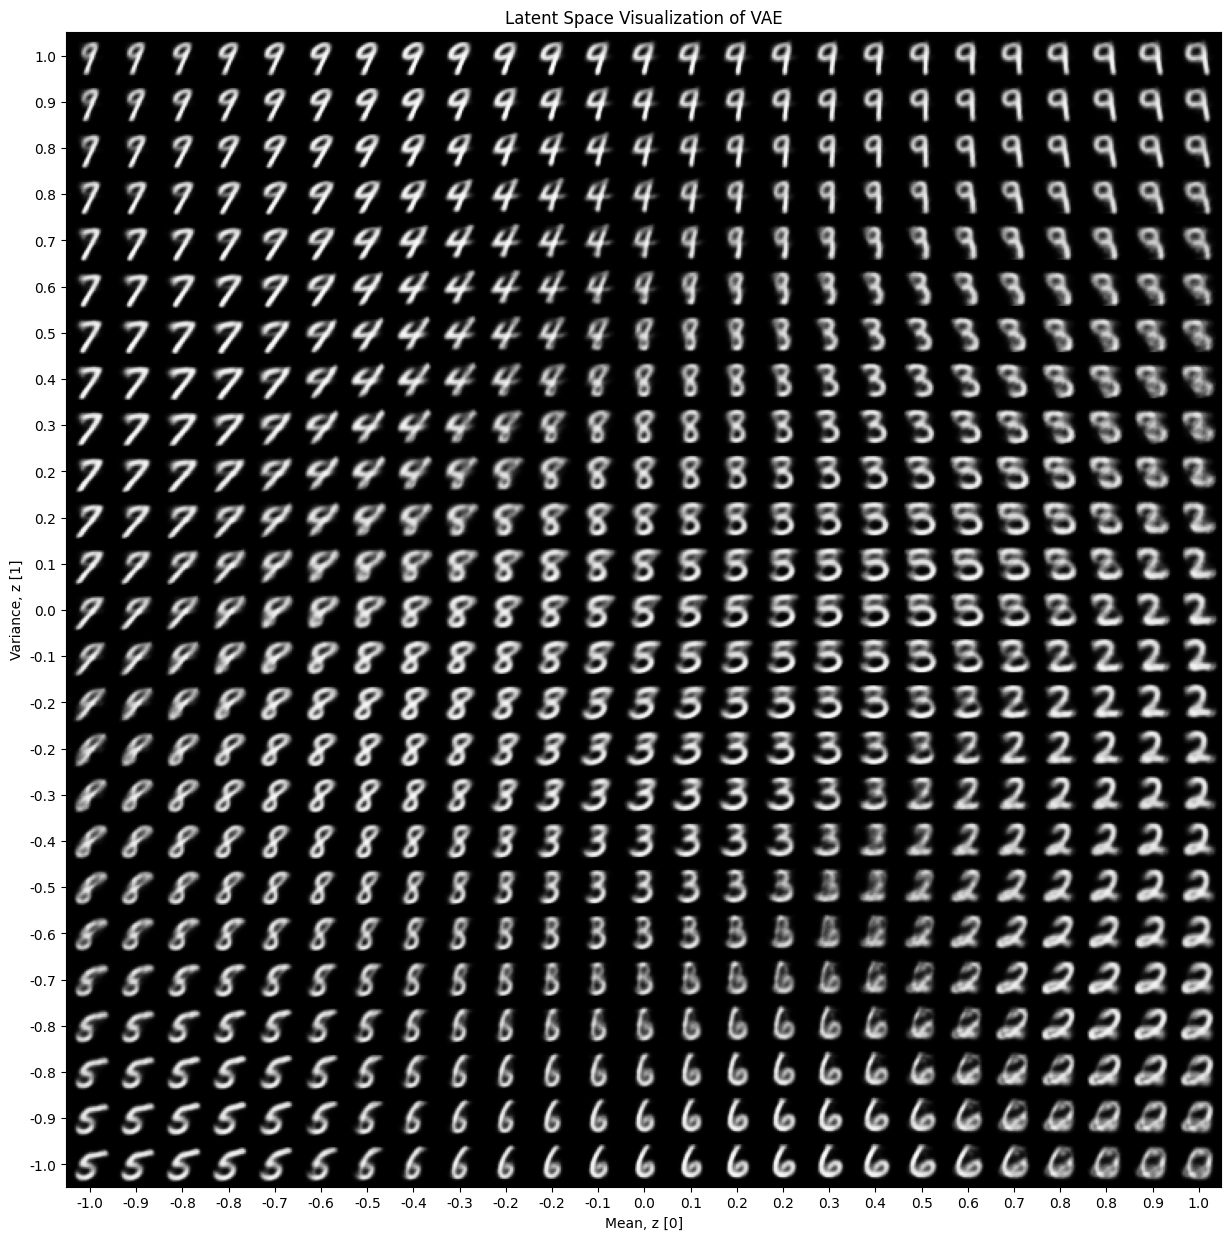

In [22]:
plot_latent_space(model)

What happens when you sample from regions outside the aformentioned space? Why? What could we expect if the network was not a variational autoencoder, but a simple autoencoder instead?

*`Your Answer:`*

 Sampling from regions outside the high-density areas of the VAE's latent space often results in the generation of unrealistic or noisy data, as the VAE is trained primarily on regions that correspond to the actual data distribution. These regions represent the "manifold" of the data; thus, points far from this manifold do not encode realistic features or patterns of the training data. This is because the VAE's decoder is not trained on latent vectors that fall outside of the high-density region, so it fails to map them to coherent outputs.

In a simple autoencoder, the latent space lacks a predefined distribution, so sampling becomes less meaningful. Unlike a VAE, an autoencoder does not learn a probabilistic model of the latent space, making it unclear how to interpret regions outside the typical latent representations. Sampling from random points in a simple autoencoder’s latent space might still yield outputs, but these are less likely to be coherent, as the latent representations were not trained to correspond to specific probability densities or to generalize to areas outside of seen samples.

